# Battle of the Neighborhoods
## How to choose the best neighborhood to live in

## Table of contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a id="introduction"></a>


The objective of this project is to find the best location to move into the Abingdon-on-Thames area.
Currently looking to move into the area of Abingdon-on-Thames and would like to take advantage of this project to use it in my favour to help me identify the best and the worst areas to live.

First step is to choose the safest borough by analysing **police crime data**. Also I need to understand the structure of the boroughs so would like to get the **Lower Layer Super Output Areas (LSOA)** for the area of interest. LSOA are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.  
Finally, then after having defined the area, get data from **FourSquare** to help us choose the best area for supermarket, leisure centres, good schools, parks and restaurants, etc.
 
Using data science tools, will help us analyse data and focus on the safest borough and explore its neighborhoods and the common venues in each neighborhood.
 
The success criteria of the project will be that after having analysed such factors, we would then be able to make the best choice for the family.

## Data <a id="data"></a>

After having defined our problem, below are the factors that will help us make our decission:

 * finding the safest area using crime data statistics
 * finding the neaby venues around the preferred areas
 * choosing the right neighbourhood within the borough
 
 We will be using the geographical coordinates of Abingdon to plot neighbourhoods in a borough that is safe and in the city's vicinity, and finally cluster the neighborhoods, plot the crime data, get venues and present our findings.
 
 Following data sources will be needed to get the required information:
 
 - [**Step 1**: Using a real world data set from Police Data UK, get crime data for last year](#step1):  A dataset consisting of the crime statistics of each Neighbourhoof in Thames Valley along with type of crime.
 
 - [**Step 2**: Gathering LSOA and UK boundary information from Ordonance Survey of the list of boroughs around for Oxfordshire.](#step2): Borough information will be used to map the crime data data and identify a the boroughs that are best and worst.
 
 - [**Step 3**: Creating a dataset of the boroughs's location and the crime data.](#step3): This data will be consolidated and we will be able to explore more about the neighbourhood and the crime around it by plotting it on maps using Folium and perform exploratory data analysis.
 
 - [**Step 4**: Adding the dataset from FourSquare with the most common venues and the respective Neighbourhood along with co-ordinates.](#step4): This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

## **Step 1:** Using a real world data set from Police Data UK, get crime data for last year <a id="step1"></a>


####  Thames Valley Crime Report 

Properties of the Crime Report

*   CRIME ID - Crime type
*   MONTH - Recorded month
*   REPORTED BY - authority who reported it
*   FALLS WITHIN - authority responsible
*   LONGITUDE - GPS longtitude
*   LATITUDE - GPS latitude
*   LOCATION - where was the crime
*   LSOA code - borough code where it falls 
*   LSOA name - borough name where it falls
*   CRIME TYPE - type of crime 

Data set URL: https://data.police.uk

## Import all the libraries that are needed beforehand

In [4]:
import time
import numpy as np  # data vectors
import pandas as pd # data analysis
from collections import Counter
from pandas.io.json import json_normalize # transform json into pandas dataframe
import matplotlib.cm as cm #plotting
import matplotlib.colors as colors
import matplotlib.pyplot as py
import json
import requests
from geopy.geocoders import Nominatim #get lat and long
from sklearn.cluster import KMeans #clustering
import folium #visualise map
import os
import geopandas as gpd
import earthpy as et
from folium.plugins import HeatMap
import geopandas
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from shapely.geometry import box # Load the box module from shapely to create box objects
from shapely.geometry import shape
import earthpy as et
import seaborn as sns

## Reading from the Dataset

Due to the amount of data, for this project, I limited the data for one year to include the year of 2019.
Get the CSV file for the Crime data from the Police database data.police.uk

In [15]:
CSV = pd.read_csv("ThamesValleyCRIMEDATA.csv")
CSV.head()

Crime ID    Month  \
0  3d294010dbca88ade8b95964f03d79dae86cbece156e32...  2019-08   
1  dbcbf4f976221e1e202c7019f2803f9ba80a8e1c8881d9...  2019-08   
2  95569239a93eb375ef1a30f147975303c0aaa322755be2...  2019-08   
3  cdb82cca5ab21305455295afad2e04a4f2b4b2066d2709...  2019-08   
4  f94e1c275753292c47a748c7241c75beb667817009ef96...  2019-08   

            Reported by          Falls within  Longitude   Latitude  \
0  Thames Valley Police  Thames Valley Police  -1.327884  51.753488   
1  Thames Valley Police  Thames Valley Police  -1.308601  51.748808   
2  Thames Valley Police  Thames Valley Police  -1.312464  51.750027   
3  Thames Valley Police  Thames Valley Police  -1.307831  51.741359   
4  Thames Valley Police  Thames Valley Police  -1.308480  51.742487   

                     Location  LSOA code                 LSOA name    WARD  \
0     On or near Eynsham Road  E01028708  Vale of White Horse 001A  Cumnor   
1  On or near Third Acre Rise  E01028709  Vale of White Horse 001B  Cumnor   
2     On or near Grange Court  E01028709  Vale of White Horse 001B  Cumnor   
3       On or near Barn Close  E01028710  Vale of White Horse 001C  Cumnor   
4     On or near Delamare Way  E01028710  Vale of White Horse 001C  Cumnor   

      GroupedArea                    Crime type  Count  
0  Abingdon Outer  Violence and sexual offences      1  
1  Abingdon Outer                      Burglary      1  
2  Abingdon Outer  Violence and sexual offences      1  
3  Abingdon Outer                   Other theft      1  
4  Abingdon Outer                  Public order      1

### Total Crimes in different Boroughs

In [16]:
CSV['Location'].value_counts()

On or near Supermarket        267
On or near Police Station     235
On or near Parking Area       187
On or near Petrol Station     101
On or near Park/Open Space     90
                             ... 
On or near Bedwells Heath       1
On or near Marines Drive        1
On or near Crabtree Road        1
On or near Tullis Close         1
On or near Cox'S Road           1
Name: Location, Length: 1069, dtype: int64

In [17]:
crime_cat_ward =pd.pivot_table(CSV,
                               values=['Count'],
                               index=['WARD'],
                               columns=['Crime type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
crime_cat_ward.head()

Count                         \
Crime type                Anti-social behaviour Bicycle theft Burglary   
WARD                                                                     
Abingdon Abbey Northcourt                   171            31       18   
Abingdon Caldecott                          104            16       14   
Abingdon Dunmore                             35             3        9   
Abingdon Fitzharris                         107            15       13   
Abingdon Peachcroft                          56             5       18   

                                                                       \
Crime type                Criminal damage and arson Drugs Other crime   
WARD                                                                    
Abingdon Abbey Northcourt                        98    24          10   
Abingdon Caldecott                               65    18           7   
Abingdon Dunmore                                 14     6           1   
Abingdon Fitzharris                              99    96          10   
Abingdon Peachcroft                              18     6           7   

                                                                          \
Crime type                Other theft Possession of weapons Public order   
WARD                                                                       
Abingdon Abbey Northcourt          39                     6           56   
Abingdon Caldecott                 28                     4           33   
Abingdon Dunmore                    2                     2            7   
Abingdon Fitzharris                28                    10           72   
Abingdon Peachcroft                12                     4           12   

                                                                     \
Crime type                Robbery Shoplifting Theft from the person   
WARD                                                                  
Abingdon Abbey Northcourt       4          56                    21   
Abingdon Caldecott              2           2                     3   
Abingdon Dunmore                0           0                     0   
Abingdon Fitzharris             1          38                     6   
Abingdon Peachcroft             2           4                     1   

                                                                           
Crime type                Vehicle crime Violence and sexual offences  All  
WARD                                                                       
Abingdon Abbey Northcourt            10                          297  841  
Abingdon Caldecott                    8                          244  548  
Abingdon Dunmore                      6                           61  146  
Abingdon Fitzharris                  24                          267  786  
Abingdon Peachcroft                  11                           89  245

In [18]:
crime_cat_area = pd.pivot_table(CSV,
                               values=['Count'],
                               index=['GroupedArea'],
                               columns=['Crime type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
crime_cat_area.head()

Count                         \
Crime type     Anti-social behaviour Bicycle theft Burglary   
GroupedArea                                                   
Abingdon Inner                   473            70       72   
Abingdon Outer                   542            54      291   
All                             1015           124      363   

                                                                        \
Crime type     Criminal damage and arson Drugs Other crime Other theft   
GroupedArea                                                              
Abingdon Inner                       294   150          35         109   
Abingdon Outer                       451   128          80         315   
All                                  745   278         115         424   

                                                                       \
Crime type     Possession of weapons Public order Robbery Shoplifting   
GroupedArea                                                             
Abingdon Inner                    26          180       9         100   
Abingdon Outer                    36          266      11         142   
All                               62          446      20         242   

                                                    \
Crime type     Theft from the person Vehicle crime   
GroupedArea                                          
Abingdon Inner                    31            59   
Abingdon Outer                    35           315   
All                               66           374   

                                                   
Crime type     Violence and sexual offences   All  
GroupedArea                                        
Abingdon Inner                          958  2566  
Abingdon Outer                         1754  4420  
All                                    2712  6986

In [19]:

crime_cat_area

Count                         \
Crime type     Anti-social behaviour Bicycle theft Burglary   
GroupedArea                                                   
Abingdon Inner                   473            70       72   
Abingdon Outer                   542            54      291   
All                             1015           124      363   

                                                                        \
Crime type     Criminal damage and arson Drugs Other crime Other theft   
GroupedArea                                                              
Abingdon Inner                       294   150          35         109   
Abingdon Outer                       451   128          80         315   
All                                  745   278         115         424   

                                                                       \
Crime type     Possession of weapons Public order Robbery Shoplifting   
GroupedArea                                                             
Abingdon Inner                    26          180       9         100   
Abingdon Outer                    36          266      11         142   
All                               62          446      20         242   

                                                    \
Crime type     Theft from the person Vehicle crime   
GroupedArea                                          
Abingdon Inner                    31            59   
Abingdon Outer                    35           315   
All                               66           374   

                                                   
Crime type     Violence and sexual offences   All  
GroupedArea                                        
Abingdon Inner                          958  2566  
Abingdon Outer                         1754  4420  
All                                    2712  6986

Pandas describe() is used to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values.

In [21]:
crime_cat_area.describe()

Count                            \
Crime type Anti-social behaviour Bicycle theft    Burglary   
count                   3.000000      3.000000    3.000000   
mean                  676.666667     82.666667  242.000000   
std                   295.029377     36.678786  151.561869   
min                   473.000000     54.000000   72.000000   
25%                   507.500000     62.000000  181.500000   
50%                   542.000000     70.000000  291.000000   
75%                   778.500000     97.000000  327.000000   
max                  1015.000000    124.000000  363.000000   

                                                                          \
Crime type Criminal damage and arson       Drugs Other crime Other theft   
count                       3.000000    3.000000    3.000000    3.000000   
mean                      496.666667  185.333333   76.666667  282.666667   
std                       228.941768   81.002058   40.104031  159.969789   
min                       294.000000  128.000000   35.000000  109.000000   
25%                       372.500000  139.000000   57.500000  212.000000   
50%                       451.000000  150.000000   80.000000  315.000000   
75%                       598.000000  214.000000   97.500000  369.500000   
max                       745.000000  278.000000  115.000000  424.000000   

                                                                      \
Crime type Possession of weapons Public order    Robbery Shoplifting   
count                   3.000000     3.000000   3.000000    3.000000   
mean                   41.333333   297.333333  13.333333  161.333333   
std                    18.583146   135.739947   5.859465   72.947470   
min                    26.000000   180.000000   9.000000  100.000000   
25%                    31.000000   223.000000  10.000000  121.000000   
50%                    36.000000   266.000000  11.000000  142.000000   
75%                    49.000000   356.000000  15.500000  192.000000   
max                    62.000000   446.000000  20.000000  242.000000   

                                                                             \
Crime type Theft from the person Vehicle crime Violence and sexual offences   
count                   3.000000      3.000000                     3.000000   
mean                   44.000000    249.333333                  1808.000000   
std                    19.157244    167.452481                   878.245979   
min                    31.000000     59.000000                   958.000000   
25%                    33.000000    187.000000                  1356.000000   
50%                    35.000000    315.000000                  1754.000000   
75%                    50.500000    344.500000                  2233.000000   
max                    66.000000    374.000000                  2712.000000   

                         
Crime type          All  
count          3.000000  
mean        4657.333333  
std         2219.537189  
min         2566.000000  
25%         3493.000000  
50%         4420.000000  
75%         5703.000000  
max         6986.000000

Exploring the data by visualising the crimes per ward

In [22]:
crime_cat_area.reset_index(inplace = True)
crime_cat_area.columns = crime_cat_area.columns.map(''.join)
crime_cat_area.rename(columns={'CountAll':'Total',
                          'CountAnti-social behaviour':'Antisocial',
                          'CountBicycle theft': 'Bike Theft',
                         'CountBurglary':'Burglary',
                         'CountCriminal damage and arson':'Criminal damage',
                         'CountDrugs':'Drugs',
                         'CountOther crime':'Other crime',
                         'CountOther theft':'Other theft',
                         'CountPossession of weapons':'Possession of weapons',
                         'CountPublic order':'Public order',
                         'CountRobbery':'Robbery',
                         'CountShoplifting':'Shoplifting',
                         'CountTheft from the person':'Theft from the person',
                         'CountVehicle crime':'Vehicle crime',
                         'CountViolence and sexual offences':'Violence and sexual offences'}, inplace=True)
crime_cat_area.head()

GroupedArea  Antisocial  Bike Theft  Burglary  Criminal damage  Drugs  \
0  Abingdon Inner         473          70        72              294    150   
1  Abingdon Outer         542          54       291              451    128   
2             All        1015         124       363              745    278   

   Other crime  Other theft  Possession of weapons  Public order  Robbery  \
0           35          109                     26           180        9   
1           80          315                     36           266       11   
2          115          424                     62           446       20   

   Shoplifting  Theft from the person  Vehicle crime  \
0          100                     31             59   
1          142                     35            315   
2          242                     66            374   

   Violence and sexual offences  Total  
0                           958   2566  
1                          1754   4420  
2                          2712   6986

In [23]:
crime_cat_ward.reset_index(inplace = True)
crime_cat_ward.columns = crime_cat_ward.columns.map(''.join)
crime_cat_ward.rename(columns={'CountAll':'Total',
                          'CountAnti-social behaviour':'Antisocial',
                          'CountBicycle theft': 'Bike Theft',
                         'CountBurglary':'Burglary',
                         'CountCriminal damage and arson':'Criminal damage',
                         'CountDrugs':'Drugs',
                         'CountOther crime':'Other crime',
                         'CountOther theft':'Other theft',
                         'CountPossession of weapons':'Possession of weapons',
                         'CountPublic order':'Public order',
                         'CountRobbery':'Robbery',
                         'CountShoplifting':'Shoplifting',
                         'CountTheft from the person':'Theft from the person',
                         'CountVehicle crime':'Vehicle crime',
                         'CountViolence and sexual offences':'Violence and sexual offences'}, inplace=True)
crime_cat_ward.head()

WARD  Antisocial  Bike Theft  Burglary  \
0  Abingdon Abbey Northcourt         171          31        18   
1         Abingdon Caldecott         104          16        14   
2           Abingdon Dunmore          35           3         9   
3        Abingdon Fitzharris         107          15        13   
4        Abingdon Peachcroft          56           5        18   

   Criminal damage  Drugs  Other crime  Other theft  Possession of weapons  \
0               98     24           10           39                      6   
1               65     18            7           28                      4   
2               14      6            1            2                      2   
3               99     96           10           28                     10   
4               18      6            7           12                      4   

   Public order  Robbery  Shoplifting  Theft from the person  Vehicle crime  \
0            56        4           56                     21             10   
1            33        2            2                      3              8   
2             7        0            0                      0              6   
3            72        1           38                      6             24   
4            12        2            4                      1             11   

   Violence and sexual offences  Total  
0                           297    841  
1                           244    548  
2                            61    146  
3                           267    786  
4                            89    245

In [24]:
crime_cat_ward.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = crime_cat_ward.iloc[1:6]
crime_neigh_top5

WARD  Antisocial  Bike Theft  Burglary  \
0   Abingdon Abbey Northcourt         171          31        18   
3         Abingdon Fitzharris         107          15        13   
21           Wantage Charlton         145           2        17   
1          Abingdon Caldecott         104          16        14   
9                   Faringdon          53           3        20   

    Criminal damage  Drugs  Other crime  Other theft  Possession of weapons  \
0                98     24           10           39                      6   
3                99     96           10           28                     10   
21               72     18            6           35                     12   
1                65     18            7           28                      4   
9                40     21            6           31                      0   

    Public order  Robbery  Shoplifting  Theft from the person  Vehicle crime  \
0             56        4           56                     21             10   
3             72        1           38                      6             24   
21            39        5           35                     15             24   
1             33        2            2                      3              8   
9             33        0           16                      3             19   

    Violence and sexual offences  Total  
0                            297    841  
3                            267    786  
21                           215    640  
1                            244    548  
9                            185    430

Five neighborhoods with highest crime

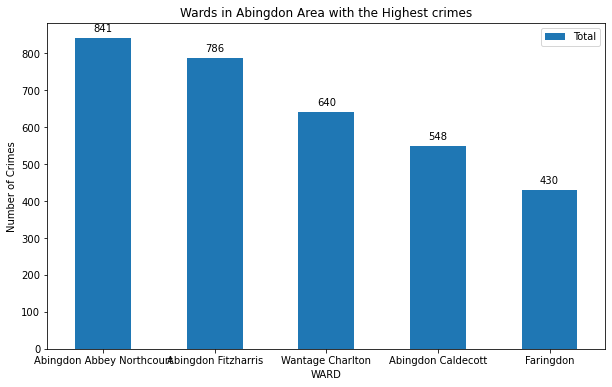

In [25]:
per_neigh = crime_neigh_top5[['WARD','Total']]

per_neigh.set_index('WARD',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('WARD')
ax.set_title('Wards in Abingdon Area with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 10,
               )

plt.show()

Five Neighborhoods with lowest crime

In [26]:
crime_neigh_low = crime_cat_ward.tail(5)

crime_neigh_low

WARD  Antisocial  Bike Theft  Burglary  Criminal damage  \
11           Hendreds          13           2        10               14   
18   Sutton Courtenay          15           2         3               10   
14            Marcham           5           2         3               19   
15           Ridgeway          14           0        10               15   
13  Kingston Bagpuize           7           2         1                5   

    Drugs  Other crime  Other theft  Possession of weapons  Public order  \
11      4            1           16                      1            10   
18      2            4            4                      0             8   
14      4            1            9                      0             5   
15      2            1            7                      1             3   
13      0            0            8                      1             4   

    Robbery  Shoplifting  Theft from the person  Vehicle crime  \
11        0            1                      1             14   
18        0            0                      1             12   
14        0            0                      1              4   
15        0            0                      1              7   
13        1            9                      0              8   

    Violence and sexual offences  Total  
11                            46    133  
18                            62    123  
14                            70    123  
15                            38     99  
13                            32     78

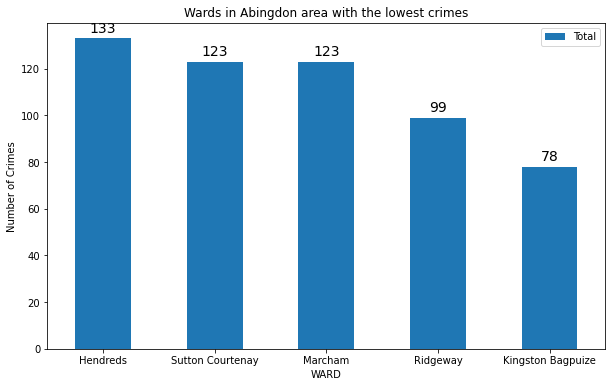

In [27]:
per_neigh = crime_neigh_low[['WARD','Total']]

per_neigh.set_index('WARD',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('WARD')
ax.set_title('Wards in Abingdon area with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

Areas in Abingdon Town with Highest Crime

In [28]:
crime_only = crime_cat_area.drop([2])
crime_only

GroupedArea  Antisocial  Bike Theft  Burglary  Criminal damage  Drugs  \
0  Abingdon Inner         473          70        72              294    150   
1  Abingdon Outer         542          54       291              451    128   

   Other crime  Other theft  Possession of weapons  Public order  Robbery  \
0           35          109                     26           180        9   
1           80          315                     36           266       11   

   Shoplifting  Theft from the person  Vehicle crime  \
0          100                     31             59   
1          142                     35            315   

   Violence and sexual offences  Total  
0                           958   2566  
1                          1754   4420

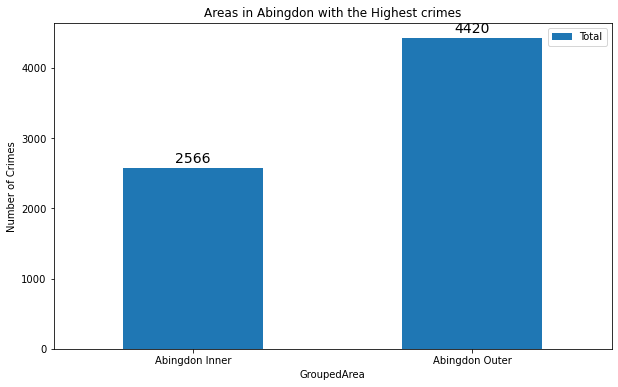

In [29]:
per_area = crime_only[['GroupedArea','Total']]

per_area.set_index('GroupedArea',inplace = True)

ax = per_area.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('GroupedArea')
ax.set_title('Areas in Abingdon with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

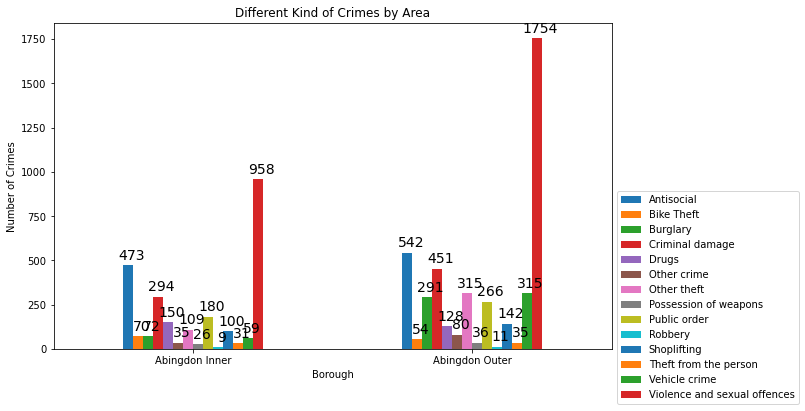

In [68]:
#area_df = crime_only[['GroupedArea']]

#area_df = area_df.sort_values(['GroupedArea'], ascending = True, axis = 0)

abi_ws = crime_only[['GroupedArea','Antisocial','Bike Theft','Burglary','Criminal damage','Drugs','Other crime','Other theft','Possession of weapons',
                  'Public order','Robbery','Shoplifting','Theft from the person','Vehicle crime','Violence and sexual offences']]


abi_ws.set_index('GroupedArea',inplace = True)

ax = abi_ws.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes by Area')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

### **Part 2:** Gathering LSOA and UK boundary information from Ordonance Survey of the list of boroughs around for Oxfordshire<a name="step2"></a>

In order to understand the boroughs, so we will get first get the shapefile for the UK Boundary from the Ordonance Survey. The way the boundaries are structured is by what is called the Lower Layer Super Output Areas (LSOA)

Get the shapefile for the UK Boundary from Ordnance Survey website

In [69]:
data = gpd.read_file('Sectors.shp')
ox_index = data[data.name == "OX"].index
ox_geom = data.loc[ox_index,'geometry']
ox_geom.head()

GeoSeries([], Name: geometry, dtype: geometry)

In [70]:
shapefile = gpd.read_file("Sectors.shp")
shapefile.head()

name                                           geometry
0  AB10 1  POLYGON ((-2.11645 57.14656, -2.11655 57.14663...
1  AB10 6  MULTIPOLYGON (((-2.12239 57.12887, -2.12279 57...
2  AB10 7  POLYGON ((-2.12239 57.12887, -2.12119 57.12972...
3  AB11 5  POLYGON ((-2.05528 57.14547, -2.05841 57.14103...
4  AB11 6  POLYGON ((-2.09818 57.13769, -2.09803 57.13852...

Get the coordinates for our desired location and save latitude and longitude

In [77]:
geo_area = pd.read_csv('ThamesValleyCRIMEDATA.csv')
geo_area.head()

Crime ID    Month  \
0  3d294010dbca88ade8b95964f03d79dae86cbece156e32...  2019-08   
1  dbcbf4f976221e1e202c7019f2803f9ba80a8e1c8881d9...  2019-08   
2  95569239a93eb375ef1a30f147975303c0aaa322755be2...  2019-08   
3  cdb82cca5ab21305455295afad2e04a4f2b4b2066d2709...  2019-08   
4  f94e1c275753292c47a748c7241c75beb667817009ef96...  2019-08   

            Reported by          Falls within  Longitude   Latitude  \
0  Thames Valley Police  Thames Valley Police  -1.327884  51.753488   
1  Thames Valley Police  Thames Valley Police  -1.308601  51.748808   
2  Thames Valley Police  Thames Valley Police  -1.312464  51.750027   
3  Thames Valley Police  Thames Valley Police  -1.307831  51.741359   
4  Thames Valley Police  Thames Valley Police  -1.308480  51.742487   

    Shape__Area  Shape__Length                    Location  LSOA code  \
0  1.340249e+07   25379.905240     On or near Eynsham Road  E01028708   
1  7.809693e+05    5479.319347  On or near Third Acre Rise  E01028709   
2  7.809693e+05    5479.319347     On or near Grange Court  E01028709   
3  3.170475e+06   11998.283340       On or near Barn Close  E01028710   
4  3.170475e+06   11998.283340     On or near Delamare Way  E01028710   

                  LSOA name    WARD     GroupedArea  \
0  Vale of White Horse 001A  Cumnor  Abingdon Outer   
1  Vale of White Horse 001B  Cumnor  Abingdon Outer   
2  Vale of White Horse 001B  Cumnor  Abingdon Outer   
3  Vale of White Horse 001C  Cumnor  Abingdon Outer   
4  Vale of White Horse 001C  Cumnor  Abingdon Outer   

                     Crime type  Count  
0  Violence and sexual offences      1  
1                      Burglary      1  
2  Violence and sexual offences      1  
3                   Other theft      1  
4                  Public order      1

In [71]:
address = 'Abingdon-on-Thames, United Kingdom'
geolocator = Nominatim(user_agent="abi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Abingdon-on-Thames, United Kingdom are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Abingdon-on-Thames, United Kingdom are 51.6714842, -1.2779715.


In [80]:
abi_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(geo_area['Latitude'], geo_area['Longitude'], geo_area['GroupedArea'], geo_area['WARD']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(abi_map)  
    
abi_map

## Methodology<a name="methodology"></a>

- [**Exploratory Data Analysis**:](#eda) Visualise the crime repots in different Oxfordshire boroughs to idenity the safest borough and normalise the neighborhoods of that borough. We will Use the resulting data and find 10 most common venues in each neighborhood.

 - Use the resulting data and get common venues around the area to find the most common venues in each neighborhood we are interested in.

#### Exploratory Data Analysis<a name="eda"></a>

- Filtered and grouped the crime data by LSOA to add the number of crimes within each area and obtain a longitude and latitude

In [13]:
Grouped = pd.DataFrame({'Value' : CSV.groupby( ['LSOA code']).size()}).reset_index()
#need them as numpy
temp1 = Grouped.to_numpy()
newdf = pd.DataFrame(data=temp1, index=None, columns=["LSOA code", "Value"])
#merge right to get back LSOA and one 'central' lat/long so first drop duplicates 
df3 = CSV.drop_duplicates(subset='LSOA code', keep="first")
Temp = newdf.merge(df3, left_on='LSOA code', right_on='LSOA code', how='right')
#Temp.drop_duplicates(subset="LSOA code",keep="first", inplace=True)
Temp['Latitude'] = Temp['Latitude'].astype(float)
Temp['Longitude'] = Temp['Longitude'].astype(float)
Temp['Value'] = Temp['Value'].astype(int)
Temp.head()

LSOA code  Value                                           Crime ID  \
0  E01028688     34                                                NaN   
1  E01028689    108  b4ebf9704f6345bf13bae104f70440a696b3cdca7efa7f...   
2  E01028690    100                                                NaN   
3  E01028691    102  17d8923859afa39df21101abe4be0a7cea4c60e3d5e588...   
4  E01028692    130                                                NaN   

     Month           Reported by          Falls within  Longitude   Latitude  \
0  2019-08  Thames Valley Police  Thames Valley Police  -1.269892  51.673533   
1  2019-08  Thames Valley Police  Thames Valley Police  -1.260667  51.675202   
2  2019-08  Thames Valley Police  Thames Valley Police  -1.284287  51.661178   
3  2019-08  Thames Valley Police  Thames Valley Police  -1.289920  51.659692   
4  2019-08  Thames Valley Police  Thames Valley Police  -1.290685  51.663491   

                   Location                 LSOA name  \
0  On or near Curtis Avenue  Vale of White Horse 005A   
1     On or near Nyatt Road  Vale of White Horse 005B   
2       On or near Townsend  Vale of White Horse 008A   
3   On or near Pudsey Close  Vale of White Horse 008B   
4    On or near Saxton Road  Vale of White Horse 008C   

                     Crime type  Count  
0         Anti-social behaviour      1  
1                 Bicycle theft      1  
2         Anti-social behaviour      1  
3  Violence and sexual offences      1  
4         Anti-social behaviour      1

In [14]:
#Making a simple table for values as with the Temp the folium wasn't working
Mapme = Temp[['Value','Latitude','Longitude']].copy()